a

Training data shape: (50000, 3072)
Training labels shape: (50000,)
Test data shape: (10000, 3072)
Test labels shape: (10000,)
Label names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Sample 0:


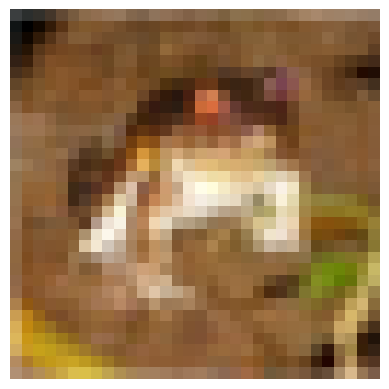

Label: 6
Label name: frog

Sample 1:


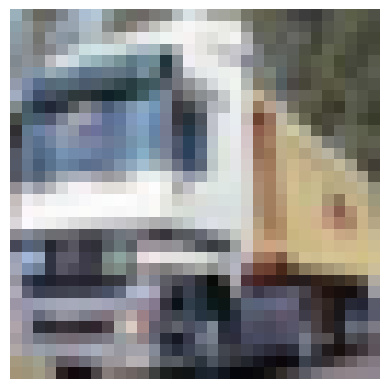

Label: 9
Label name: truck

Sample 2:


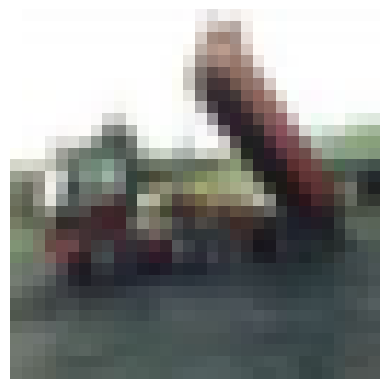

Label: 9
Label name: truck

Sample 3:


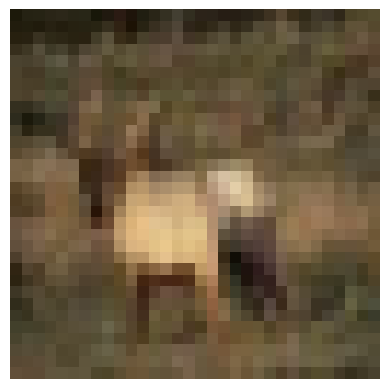

Label: 4
Label name: deer

Sample 4:


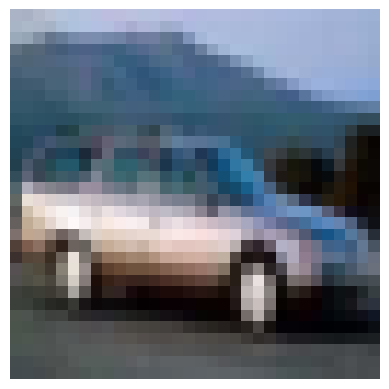

Label: 1
Label name: automobile



In [8]:
import pickle
import numpy as np

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def load_cifar10_data(data_dir):
    """
    Load CIFAR-10 dataset from the specified directory.
    
    Args:
        data_dir (str): Path to the directory containing CIFAR-10 data files.
    
    Returns:
        tuple: A tuple containing training and test data and labels.
    """
    # Load training data
    train_data = []
    train_labels = []
    for i in range(1, 6):
        batch = unpickle(f"{data_dir}/data_batch_{i}")
        train_data.append(batch[b'data'])
        train_labels.append(batch[b'labels'])
    
    # Concatenate all training batches
    train_data = np.concatenate(train_data)
    train_labels = np.concatenate(train_labels)
    
    # Load test data
    test_batch = unpickle(f"{data_dir}/test_batch")
    test_data = test_batch[b'data']
    test_labels = np.array(test_batch[b'labels'])
    
    return (train_data, np.array(train_labels)), (test_data, test_labels)

def load_cifar10_labels(data_dir):
    """
    Load CIFAR-10 labels from the specified directory.
    
    Args:
        data_dir (str): Path to the directory containing CIFAR-10 label files.
    
    Returns:
        list: A list of class names for CIFAR-10 dataset.
    """
    # Load label names
    meta = unpickle(f"{data_dir}/batches.meta")
    label_names = meta[b'label_names']
    
    # Decode byte strings to UTF-8
    label_names = [name.decode('utf-8') for name in label_names]
    
    return label_names

data_dir = "data"  # Change this to your CIFAR-10 data directory
(train_data, train_labels), (test_data, test_labels) = load_cifar10_data(data_dir)
label_names = load_cifar10_labels(data_dir)

print("Training data shape:", train_data.shape)
print("Training labels shape:", train_labels.shape)
print("Test data shape:", test_data.shape)
print("Test labels shape:", test_labels.shape)
print("Label names:", label_names)

# preview the first 5 training samples
for i in range(5):
    print(f"Sample {i}:")
    # create image from the data
    image = train_data[i].reshape(3, 32, 32).transpose(1, 2, 0)

    import matplotlib.pyplot as plt
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    print("Label:", train_labels[i])
    print("Label name:", label_names[train_labels[i]])
    print()

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np

# 1. Load the CIFAR-10 Dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# 2. Preprocess the Data

#   a. Normalize Pixel Values: Scale pixel values to the range [0, 1].
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

#   b. One-Hot Encode Labels: Convert integer labels to one-hot vectors.
num_classes = 10  # CIFAR-10 has 10 classes
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# 3. Split into Training and Validation Sets (optional, but good practice)
#    This helps monitor overfitting and tune hyperparameters.
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)


# 4. Build the CNN Model

model = Sequential()

# --- Convolutional Layers ---
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=x_train.shape[1:]))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

# --- Fully Connected (Dense) Layers ---
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))  # Output layer (10 classes, softmax)

# 5. Compile the Model
optimizer = Adam(learning_rate=0.001) #or use the string "adam"
model.compile(optimizer=optimizer,
              loss=CategoricalCrossentropy(),
              metrics=[CategoricalAccuracy()])

model.summary() # Print a summary of the model architecture


# 6. Train the Model

# --- Callbacks (Optional, but highly recommended) ---
#    a. Early Stopping: Stop training if validation loss doesn't improve.
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

#    b. Model Checkpoint: Save the best model weights during training.
model_checkpoint = ModelCheckpoint('best_cifar10_model.h5', monitor='val_loss', save_best_only=True)


batch_size = 64  # Experiment with different batch sizes
epochs = 50    # Start with a reasonable number, adjust based on training

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(x_val, y_val),
                    callbacks=[early_stopping, model_checkpoint], # Use callbacks
                    shuffle=True) #Shuffle training data each epoch


# 7. Evaluate the Model

loss, accuracy = model.evaluate(x_test, y_test, verbose=0)  # Evaluate on the test set
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

# 8. Plot Training History (Optional, but very useful)

plt.figure(figsize=(12, 4))

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()


# 9. Make Predictions (Optional)

predictions = model.predict(x_test)
predicted_classes = np.argmax(predictions, axis=1)  # Convert one-hot to class labels
true_classes = np.argmax(y_test, axis=1)

# 10. Confusion Matrix and Classification Report (Optional)
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(true_classes, predicted_classes))

#11.  Save the Trained Model (Optional)
model.save('cifar10_model.h5') #Save the whole model

#You can later reload it like this:
# from tensorflow.keras.models import load_model
# loaded_model = load_model('cifar10_model.h5')

2025-03-22 09:53:24.444500: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-22 09:53:24.451908: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742637204.460456   75972 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742637204.462699   75972 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742637204.468674   75972 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


/home/jack/College/DataSciML/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-03-22 09:53:40.654365: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 816,938 (3.12 MB)

 Trainable params: 815,530 (3.11 MB)

 Non-trainable params: 1,408 (5.50 KB)

Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - categorical_accuracy: 0.3437 - loss: 2.0947

625/625 ━━━━━━━━━━━━━━━━━━━━ 88s 137ms/step - categorical_accuracy: 0.3439 - loss: 2.0941 - val_categorical_accuracy: 0.4753 - val_loss: 1.6034
Epoch 2/50
388/625 ━━━━━━━━━━━━━━━━━━━━ 29s 126ms/step - categorical_accuracy: 0.5636 - loss: 1.2315

KeyboardInterrupt: 